In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import os
import time
from torch.autograd import Variable

In [2]:
train_dir = './data/train_valid/train'
valid_dir = './data/train_valid/valid'

In [3]:
# Preprocess the data
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.08, 1.0), ratio=(3.0/4.0, 4.0/3.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [4]:
# Load the datasets with ImageFolder and preprocess
train_data = torchvision.datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = torchvision.datasets.ImageFolder(valid_dir, transform=valid_transforms)

# Use the datasets and the transforms to define the dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=128, shuffle=True)

In [5]:
# Adjust the learning rate
def lr_scheduler(optimizer, epoch, init_lr=0.01, lr_decay_epoch=10):
    lr = init_lr * (0.8 ** (epoch // lr_decay_epoch))
    print('LR is set to {}'.format(lr))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer

In [6]:
use_gpu = torch.cuda.is_available()
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
num_epochs = 30

# Load the model
model_ft = nn.Sequential()
model_ft.features = torchvision.models.resnet50(pretrained=True)
# Change the classify layer
model_ft.output_new = nn.Sequential(nn.Linear(1000, 512), nn.ReLU(), nn.Linear(512, 120))
# Freeze the parameter
for param in model_ft.features.parameters():
    param.requires_grad = False
# Use CrossEntropyLoss as the loss function
criterion = nn.CrossEntropyLoss()
# Use SGD as the optimizer
optimizer = optim.SGD((model_ft.parameters()), lr=0.01, momentum=0.9, weight_decay=1e-4)
if use_gpu:
    model_ft = model_ft.cuda()
    criterion = criterion.cuda()

print('Start Training')
total_step = len(train_loader)
best_acc = 0
model_ft.train(True)
record_train = list()
record_valid = list()
loss_record_train = list()
loss_record_valid = list()

for epoch in range(num_epochs):
    # Save the training process
    mylog = open('ResNet50_training_progress.log', mode='a', encoding='utf-8')
    print("========== epoch: [{}/{}] ==========".format(epoch + 1, num_epochs), file=mylog)
    print("========== epoch: [{}/{}] ==========".format(epoch + 1, num_epochs))
    num_correct = 0
    num_total = 0
    
    start = time.time()
    # Adjust the learning rate
    optimizer = lr_scheduler(optimizer, epoch)
    # Initialize training loss
    train_loss = 0.0
    valid_loss = 0.0
    # Start training the model
    for i, (inputs, labels) in enumerate(train_loader):
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        # Clear the gradient
        optimizer.zero_grad()
        # Feed forward
        outputs = model_ft(inputs)
        loss = criterion(outputs, labels)
        # Back propagation
        loss.backward()
        optimizer.step()
        # Predict
        _, prediction = torch.max(outputs.data, 1)
        num_total += labels.size(0)
        num_correct += torch.sum(prediction == labels.data)
        train_acc = 100.0 * num_correct / num_total
        train_loss = train_loss + ((1 / (i + 1)) * (loss.data - train_loss)) 

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Training Loss: {:.4f} | Training accuracy: {:6.3f}%'.
                  format(epoch + 1, num_epochs, i + 1, total_step, train_loss, train_acc))
            print('Epoch [{}/{}], Step [{}/{}], Training Loss: {:.4f} | Training accuracy: {:6.3f}%'.
                  format(epoch + 1, num_epochs, i + 1, total_step, train_loss, train_acc), file=mylog)

    record_train.append(train_acc)
    loss_record_train.append(loss.item())
    print('Epoch {}, Training Loss: {:.3f} | Training accuracy: {:6.3f}%'.format(epoch + 1, train_loss, train_acc))
    print('Epoch {}, Training Loss: {:.3f} | Training accuracy: {:6.3f}%'.format(epoch + 1, train_loss, train_acc), file=mylog)
    print("--- cost time: {:.4f}s ---".format(time.time() - start))
    print("--- cost time: {:.4f}s ---".format(time.time() - start), file=mylog)

    # test on the validation set
    print("*************** valid ***************")
    print("*************** valid ***************", file=mylog)
    with torch.no_grad():
        num_correct = 0
        num_total = 0
        for i, (inputs, labels) in enumerate(valid_loader):
            model_ft.eval()
            inputs = torch.autograd.Variable(inputs.cuda())
            labels = torch.autograd.Variable(labels.cuda())

            outputs = model_ft(inputs)
            loss = criterion(outputs, labels)
            valid_loss += ((1 / (i + 1)) * (loss.data - valid_loss))
            _, prediction = torch.max(outputs.data, 1)
            num_total += labels.size(0)
            num_correct += torch.sum(prediction == labels.data).item()

    valid_acc = 100 * num_correct / num_total
    if valid_acc > best_acc:
        best_acc = valid_acc
        # save the best model
        model_name = "ResNet50_savedModel.pth"
        torch.save(model_ft, model_name)
        print("The beat accuracy on the validation set is improved to " + str(best_acc) + "! Model saved to " + model_name)
    
    record_valid.append(valid_acc)
    loss_record_valid.append(valid_loss)
    print("Validation Loss: {:.3f} | Validation accuracy: {:6.3f}%".format(valid_loss, valid_acc))
    print("Validation Loss: {:.3f} | Validation accuracy: {:6.3f}%".format(valid_loss, valid_acc), file=mylog)
    print("************************************\n")
    print("************************************\n", file=mylog)
    mylog.close()
    
print("Training finished!")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/featurize/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Start Training
========== epoch: [1/30] ==========
LR is set to 0.01
Epoch 1, Training Loss: 2.690 | Training accuracy: 39.217%
--- cost time: 76.0543s ---
*************** valid ***************
The beat accuracy on the validation set is improved to 75.34246575342466! Model saved to ResNet50_savedModel.pth
Validation Loss: 0.806 | Validation accuracy: 75.342%
************************************

========== epoch: [2/30] ==========
LR is set to 0.01
Epoch 2, Training Loss: 1.256 | Training accuracy: 65.772%
--- cost time: 75.7847s ---
*************** valid ***************
The beat accuracy on the validation set is improved to 81.80039138943249! Model saved to ResNet50_savedModel.pth
Validation Loss: 0.600 | Validation accuracy: 81.800%
************************************

========== epoch: [3/30] ==========
LR is set to 0.01
Epoch 3, Training Loss: 1.126 | Training accuracy: 68.913%
--- cost time: 75.7052s ---
*************** valid ***************
The beat accuracy on the validation se

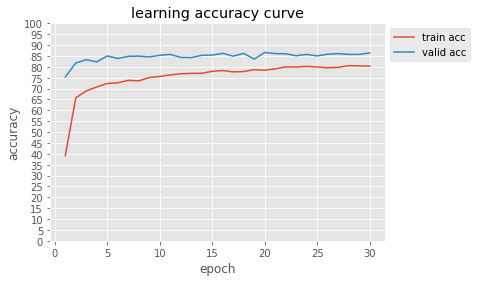

In [11]:
# Visualize the change of the accuracy
train_acc_result = []
for record in record_train:
    train_acc_result.append(record.cuda().data.cpu().numpy())

plt.style.use("ggplot")
plt.plot(range(1, len(train_acc_result) + 1), train_acc_result, label="train acc")
if record_valid is not None:
    plt.plot(range(1, len(record_valid) + 1), record_valid, label="valid acc")

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("learning accuracy curve")
plt.xticks(range(0, len(train_acc_result) + 1, 5))
plt.yticks(range(0, 101, 5))
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

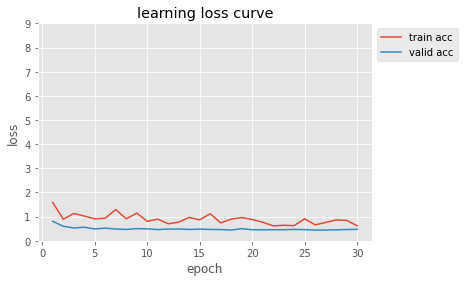

In [12]:
# Visualize the change of the loss
train_loss_result = []
for record in loss_record_train:
    train_loss_result.append(record)

plt.style.use("ggplot")
plt.plot(range(1, len(train_loss_result) + 1), train_loss_result, label="train acc")

valid_loss_result = []
for record in loss_record_valid:
    valid_loss_result.append(record.cuda().data.cpu().numpy())
plt.plot(range(1, len(valid_loss_result) + 1), valid_loss_result, label="valid acc")

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("learning loss curve")
plt.xticks(range(0, len(train_loss_result) + 1, 5))
plt.yticks(range(0, 10, 1))
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()